In [148]:
#import data and stuff
import numpy as np
from numpy import linalg as lin
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.datasets import load_digits
import sklearn.decomposition as sk
images, labels = load_digits(2, return_X_y = True)

#Labeled training set
training_images = images[:300]
training_labels = labels[:300]

#Labeled test set 
test_images = images[300:]
test_labels = labels[300:]    

training_images = training_images.transpose()
len(training_images[0,:])

300

In [149]:

#Calculate mean vector
#each image is a column, each pixel is an entry in that column
m = np.zeros((64,1))
#for each row
for i in range(len(training_images[:,0])):
    m[i,0] = np.mean(training_images[i,:])
    
    
for i in range(len(training_images[0,:])):
    for j in range(len(m[:,0])):
        training_images[j,i] = training_images[j,i] - m [j]
#Figure out which rows are ones and which are zeros
indices_0 = np.where(training_labels == 0)
indices_1 = np.where(training_labels == 1)


In [150]:
#Calculate principal components
X = training_images @ training_images.transpose()
vals, vecs = lin.eig(X)
#Principal components
PC = np.vstack((vecs[:,0], vecs[:,1]))
# Calculate feature vectors
feature_vectors = PC @ training_images
feature_vectors.shape

(2, 300)

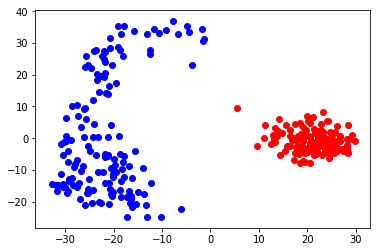

In [151]:
#plotting zeros and ones
zeros = feature_vectors.transpose()[indices_0]
ones = feature_vectors.transpose()[indices_1]
plt.scatter(zeros[:,0], zeros[:,1], color = 'red')
plt.scatter(ones[:,0], ones[:,1], color = 'blue')


In [152]:
def kNNClassify(feature_vectors, labels, data, k):
    distances = np.zeros((1,len(feature_vectors[0,:])));
    reference = np.vstack((distances,labels))
    neighbors = []
    for i in range(len(reference[0,:])):
           reference[0,i] = np.sqrt((data[0] - feature_vectors[0,i])**2 + (data[1] - feature_vectors[1,i])**2)
    
    reference = reference[:, reference[0].argsort()]
    for i in range(k):
        neighbors.append(reference[-1,i])
    return np.bincount(neighbors).argmax()

In [153]:
class_labels = [];
kNNClassify(feature_vectors,training_labels,PC @ test_images[1] , 5)
PC @ test_images[1]
#Classify data
for i in range(len(test_images)):
    class_labels.append(kNNClassify(feature_vectors,training_labels,PC @ test_images[i] , 5))
print(class_labels)

[0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]


In [154]:
#Calculate error
error = 0
for i in range (len(class_labels)):
    if test_labels[i] != class_labels[i]:
        error = error + 1
        
error = error/len(class_labels)
print(error)
#Looks like the error is 0

0.0


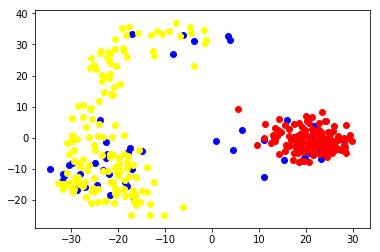

In [155]:
#I calculated the error first just to see if there would be any black points. But, since the error is 0,
#I can just plot all the points as blue

#First transform them with the principal components
test_image_features = PC @ test_images.transpose()
#Plotting them on top of the training image features just to show that they were classified correctly
#Also I'm changing the color of ones to yellow

#Plot classified data
plt.scatter(test_image_features[0,:], test_image_features[1,:], color ='blue')
#Plot training data
plt.scatter(zeros[:,0], zeros[:,1], color = 'red')
plt.scatter(ones[:,0], ones[:,1], color = 'yellow')


In [156]:
#kNN using higher dimensional features
#We need to find k such that 95% of the variance is preserved. In other words, we want PCA_Error < 5%
#Basically, we need to calculate the SVD of the data, and find k such that the sum from k + 1 to N of (sing_vals)^2 < 5

#Calculate SVD of training_images
u, s, vh = lin.svd(training_images)

#frobenius norm of training_images ^ 2
FN_b = lin.norm(training_images,'fro')**2

captured_variation = 0;
k = 0
while(captured_variation < .95):
    captured_variation = captured_variation + s[k]**2/FN_b
    k = k+1
    
print(k)
#We need 19 principal components
#Define new feature vectors
PC19 = vecs[:,0:19]
feature_vectors19 = PC19.transpose() @ training_images
feature_vectors19.shape

19


(19, 300)

In [157]:
def kNNClassify1(feature_vectors, labels, data, k):
    distances = np.zeros((1,len(feature_vectors[0,:])));
    reference = np.vstack((distances,labels))
    neighbors = []
    
    for i in range(len(reference[0,:])):
        sum = 0
        for j in range(len(feature_vectors[:,0])):
            sum = sum + (data[j] - feature_vectors[j,i])**2
        reference[0,i] = np.sqrt(sum)
    
    reference = reference[:, reference[0].argsort()]
    for i in range(k):
        neighbors.append(reference[-1,i])
    return np.bincount(neighbors).argmax()

In [176]:
classified_labels19 = np.zeros((10, len(test_labels)))
for k in range(1,10,2):
    for i in range(len(test_images)):
        classified_labels19[k, i] = (kNNClassify1(feature_vectors19, training_labels, PC19.transpose() @ test_images[i], k))

#Calculate error

error = []
for k in range(len(classified_labels19[:,0])):
    error_temp = 0
    for i in range (len(classified_labels19)):
        if test_labels[i] != classified_labels19[k,i]:
            error_temp = error_temp + 1
    error.append(error_temp)
    
#Average error vector
#Get only odd values because the even entries are garbage
error = error[1::2]
print(error)

[0, 0, 0, 0, 0]


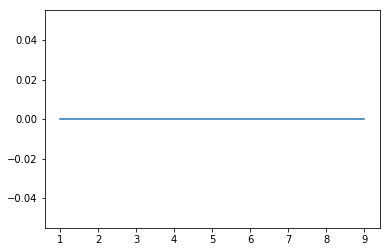

In [180]:
#The assignment says to plot error vs k. 
#It's just gonna be a horizontal line since nothing was classified incorrectly

plt.plot([1, 3, 5, 7, 9], error)

#I would recommend k = 1 for this particular problem. Although, that's probably not good enough for most kNN problems. 
#95% of the info was preserved and 0 and 1 are different enough that it's difficult to misclassiy them, so no images
#were mis-classified in this case